Is your Neural Network cheating?
===

When I first read about neural networks, it made an impression of a big bulky box with thousands of parameters who would just munch on any and all kinds of data under the Sun and magically pop out the state of the art  accuracy score.  I felt bad that all the carefully engineered algorithms would fall behind them in performance. It felt like a shortcut, wherein instead of researching deep into the problem, people just use nets to get the "best" results and publish papers.

Until recently, when I came across Jason Yosinki's work[^yos] where they try to reconstruct images of particular classes from trained Convolutional Neural Networks. Following this thread, I found a long string of work by many researchers aimed to go beyond the accuracies and F1-scores to find what these CNNs want to see in the image to give a confident classification. There is an interesting (and maybe humorous) anecdote   [here](https://neil.fraser.name/writing/tank/)  on why you should be interested in doing so.

How difficult is it to discriminate between images? In this blogpost, I have tried to explore this question. 

This blog is actually the markdown view of an IPython notebook. You can download this entire page (both the code and text by downloading the notebook [here](resources/notebook.py)). You will need Jupyter[^jup] to open and run the notebook. 


First we'll setup our workbench using Lasagne and theano. We will be using the famous MNIST dataset for our explorations.

In [51]:
import theano
import gzip
import cPickle
import PIL
from scipy.misc import bytescale
import numpy as np
from lasagne.init import Constant, GlorotUniform
import sys

theano.config.floatX='float32'
theano.config.optimizer='fast_run'
theano.config.exception_verbosity='high'

To view images inline in IPython notebook, I'm using the reference from the top answer here. 

http://stackoverflow.com/questions/8409143/quickest-way-to-preview-a-pil-image

In [19]:
# display_pil.py
# source: http://mail.scipy.org/pipermail/ipython-user/2012-March/009706.html
# by 'MinRK'
import Image
from IPython.core import display
from io import BytesIO

def display_pil_image(im):
    """displayhook function for PIL Images, rendered as PNG"""
    b = BytesIO()
    im.save(b, format='png')
    data = b.getvalue()

    ip_img = display.Image(data=data, format='png', embed=True)
    return ip_img._repr_png_()

# register display func with PNG formatter:
png_formatter = get_ipython().display_formatter.formatters['image/png']
png_formatter.for_type(Image.Image, display_pil_image)

<function __main__.display_pil_image>

The length of this post seems intimidating because of the amount of code here. I would advise you to skip the section on the training code - it exists only for the sake of completeness. 

[TOC]

# The Code (skip it?)

## Choosing two similar looking numbers


We load the MNIST dataset.

In [20]:
f=gzip.open("./mnist.pkl.gz")
mnistdata=cPickle.load(f)
train_set, valid_set, test_set = mnistdata

Take the numbers 1 and 7. The differentiating factor amongst the two is that seven will have well pronounced horizontal strokes on top, and maybe an extra on in the middle. While both 1 and 7 have a roughly vertical stroke, the distinguishing factor has to be the horizontal strokes. Let's pick these two from the dataset.

In [21]:
allones=train_set[0][np.where(train_set[1]==1)[0]]
allsevens=train_set[0][np.where(train_set[1]==7)[0]]

I would like to get an overview of how people write 1s and 7s before proceeding. These helper functions tile to make a large image from list of digit images.

In [22]:
def tile(x,m,n):
    y=x.copy().reshape((m,n,28,28))
    return np.hstack(np.hstack(y))

def getImage(x):
    im=bytescale(x)
    return PIL.Image.fromarray(im)

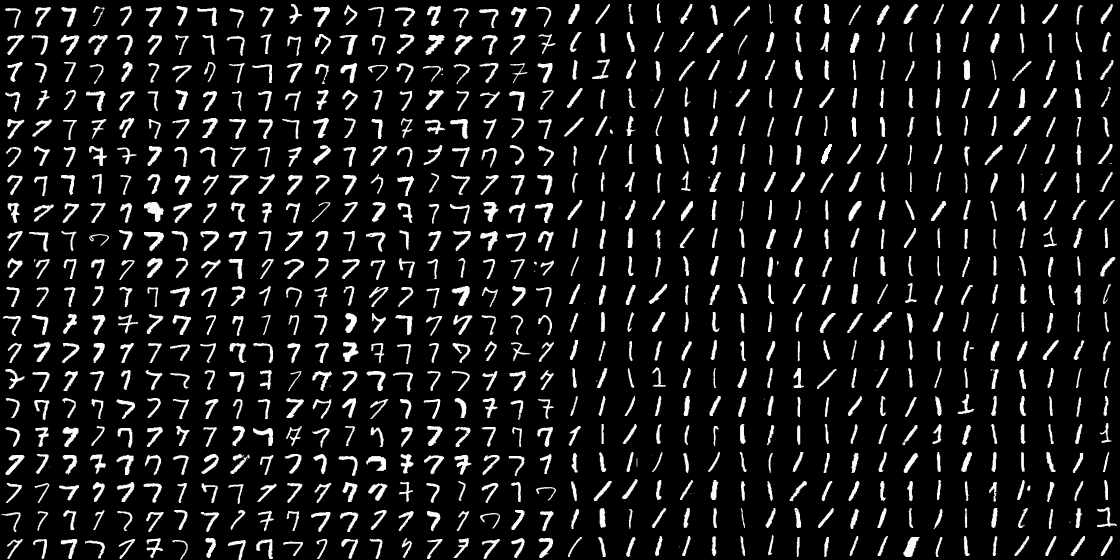

In [23]:
getImage(
    np.hstack(( tile(allsevens[np.random.permutation(allsevens.shape[0])[0:400]],20,20) , 
               tile(allones[np.random.permutation(allones.shape[0])[0:400]],20,20)  )) 
        )

Looks satisfactory. All 7s have a horizontal stroke on top, while only a few 1s have such a horizontal stroke in the same position.  Now my goal is to see that if I train a neural net to differentiate between them, then does it so happen, that if there is a horizontal line, the net says 7 and otherwise it says 1.

## Training the network
What follows next is boring code for preparing the data for binary classification.

In [24]:
numSamples=5000

permkey1=np.random.permutation(5000)[0:numSamples]
numTrain=4000
trainXs=np.concatenate((allones[permkey1][:numTrain],allsevens[permkey1][:numTrain]))
trainYs=np.concatenate((    np.zeros((numTrain))  ,  np.ones((numTrain))   ))

testXs=np.concatenate((allones[permkey1][numTrain:],allsevens[permkey1][numTrain:]))
testYs=np.concatenate((    np.zeros((numSamples - numTrain))  ,  np.ones((numSamples - numTrain))   ))

Now we come to designing the network. The design has been taken from ColinRaffael's online tutorial. Except that I've not used dropout. 

In [25]:
import lasagne
import theano.tensor as T 

ConvLayer=lasagne.layers.Conv2DLayer

def getNet():
    net={}
    net['input_var']=T.tensor4()
    net['inputlayer']=lasagne.layers.InputLayer((None,1,28,28),input_var=net['input_var'])
    net['conv1']=ConvLayer(net['inputlayer'],20,(5,5),stride=(1,1), pad='valid', nonlinearity=lasagne.nonlinearities.rectify,
                          W=GlorotUniform('relu'), b=Constant(0.0))
    net['pool1']=lasagne.layers.Pool2DLayer(net['conv1'],2)
    net['conv2']=ConvLayer(net['pool1'],50,(5,5),stride=(1,1), pad='valid', nonlinearity=lasagne.nonlinearities.rectify,
                          W=GlorotUniform('relu'), b=Constant(0.0))
    net['pool2']=lasagne.layers.Pool2DLayer(net['conv2'],2)
    net['flattened']=lasagne.layers.FlattenLayer(net['pool2'])
    net['dense1']=lasagne.layers.DenseLayer(net['flattened'], num_units=256, nonlinearity=lasagne.nonlinearities.rectify,
                                           W=GlorotUniform('relu'), b=Constant(0.0))
    net['dense2']=lasagne.layers.DenseLayer(net['dense1'], num_units=2, nonlinearity=lasagne.nonlinearities.softmax,
                                           W=GlorotUniform() )
    net['output']=net['dense2']
    return net

In [40]:
#code modified form of ColinRafaels's code

cnn=getNet()

true_output = T.imatrix('true_output')
netoutput=lasagne.layers.get_output(cnn['output'])
loss_train = lasagne.objectives.categorical_crossentropy(netoutput, true_output)

all_params = lasagne.layers.get_all_params(cnn['output'])

aggregate_loss=lasagne.objectives.aggregate(loss_train)

# Use ADADELTA for updates
updates = lasagne.updates.adadelta(aggregate_loss, all_params)

train = theano.function([cnn['input_var'], true_output], loss_train, updates=updates)
# This is the function we'll use to compute the network's output given an input
# (e.g., for computing accuracy).
get_output = theano.function([cnn['input_var']], netoutput)

In [41]:
# changing my data's tensor shapes
traindict={}
permkey2=np.random.permutation(trainXs.shape[0])
traindict['X']=trainXs[permkey2].reshape(trainXs.shape[0],1,28,28)
traindict['y']=trainYs[permkey2].astype('int32')
traindict['y']=np.asarray(map(lambda q: np.array([0,1],dtype='int32') if q==1 else  np.array([1,0],dtype='int32') 
                              ,traindict['y']))

validdict={}
validdict['X']=testXs.reshape(testXs.shape[0],1,28,28)
validdict['y']=testYs.astype('int32')
validdict['y']=np.asarray(map(lambda q: np.array([0,1],dtype='int32') if q==1 else  np.array([1,0],dtype='int32') 
                              ,validdict['y']))

dataset={}
dataset['train']=traindict
dataset['valid']=validdict

We'll now train the network in batches of 100 images. 8 epochs would be enough.

In [42]:

BATCH_SIZE = 100
N_EPOCHS = 8
# Keep track of which batch we're training with
batch_idx = 0
# Keep track of which epoch we're on
epoch = 0

print("starting the first epoch")
sys.stdout.flush()

while epoch < N_EPOCHS:
    # Extract the training data/label batch and update the parameters with it
    train(dataset['train']['X'][batch_idx:batch_idx + BATCH_SIZE],
                     dataset['train']['y'][batch_idx:batch_idx + BATCH_SIZE])
    batch_idx += BATCH_SIZE
    # Once we've trained on the entire training set...
    if batch_idx >= dataset['train']['X'].shape[0]:
        # Reset the batch index
        batch_idx = 0
        # Update the number of epochs trained
        epoch += 1
        # Compute the network's output on the validation data
        val_output = get_output(dataset['valid']['X'])
        # The predicted class is just the index of the largest probability in the output
        val_predictions = (val_output>0.5).astype("int32")
        # The accuracy is the average number of correct predictions
        accuracy = np.mean(val_predictions == dataset['valid']['y'])
        print("Epoch {} validation accuracy: {}".format(epoch, accuracy))

starting the first epoch
Epoch 1 validation accuracy: 0.9945
Epoch 2 validation accuracy: 0.995
Epoch 3 validation accuracy: 0.994
Epoch 4 validation accuracy: 0.9945
Epoch 5 validation accuracy: 0.9945
Epoch 6 validation accuracy: 0.9945
Epoch 7 validation accuracy: 0.9945
Epoch 8 validation accuracy: 0.9945


In [43]:
val_output = get_output(dataset['valid']['X'])
val_predictions=(val_output>0.5).astype('int32')
# The accuracy is the average number of correct predictions
accuracy = np.mean(val_predictions == dataset['valid']['y'])
print("Validation accuracy: {}".format( accuracy))

Validation accuracy: 0.9945


In [30]:
#Saving the model for loading later
import pickle
trainedparamvals=map(lambda q:q.eval(),all_params)
pickle.dump(trainedparamvals,open("trainedparamvals.pkl","wb"))

In [31]:
#If you have the weight file, you don't need to train the network.You can just load the weights from the disk
import pickle
trainedparamvals=pickle.load(open("./trainedparamvals.pkl","rb"))
for i,j in zip(all_params,trainedparamvals):
    i.set_value(j)

# The Results

## Testing out the model on hand drawn input

I'll now feed some hand drawn inputs to the network and see how well it does on these.

In [44]:
#Helper function for transforming opened image and feeding it into the net 
def getPred(foolingImage):
    foolingImageArr=np.array(foolingImage)
    foolingImageArr=foolingImageArr.reshape(1,1,28,28)/foolingImageArr.max()
    print(get_output(foolingImageArr))

Let's start with a normal 1.

In [45]:
foolingImage=PIL.Image.open("./normal1.jpg")
getPred(foolingImage)
foolingImage

[[ 0.94842285  0.05157717]]


The left number is the probability of being a 1 and the right one of being a 7. It clearly did well. Now a 7.

In [46]:
foolingImage=PIL.Image.open("./normal7.jpg")
getPred(foolingImage)
foolingImage

[[ 0.00326309  0.99673688]]


Everything seems right. Now let's feed in some weird data - a stright horizontal stroke.

In [47]:
foolingImage=PIL.Image.open("./fool7.jpg")
getPred(foolingImage)
foolingImage

[[  3.00072570e-04   9.99699950e-01]]


The network is overwhelmingly sure that the image is a 7. It seems that the network has learnt a simple way to score good in the tests. If it sees a horizontal stroke, it will say 7, because all 7s have horizontal strokes. Therefore it is very sure about its prediction. We obviously know that's not 7. So the notion of a 7 that the network has learnt is way different from how we humans perceive a 7. It even gets worse with the next test image.  

In [48]:
foolingImage=PIL.Image.open("./fool1.jpg")
getPred(foolingImage)
foolingImage

[[  9.99794364e-01   2.05609627e-04]]


As far as humans are concerned, we would classify the previous two as the same "symbol". However, the network learns that some 1s have a horizontal base stroke at the bottom and thinks that this is most probably a 1. 

One of the principal arguments in support of CNNs is that they are able to detect objects even when they are translated. The next two images are 1s with the exact same pixel values, which are just translated. 

In [49]:
foolingImage=PIL.Image.open("./shift1.jpg")
getPred(foolingImage)
foolingImage

[[ 0.05307976  0.94692022]]


In [50]:
foolingImage=PIL.Image.open("./shift2.jpg")
getPred(foolingImage)
foolingImage

[[ 0.98019415  0.01980587]]


One of them is classified as 7. So has the network assumed that while writing a 1, most people would start from the right side? That is something that we definitely donot want it to learn. Although I think this might be solved by data augmentation where you add randomly shifted copies of the original training images to the training data. 

## Why is this bad?

Although the shift thing can be taken care of by data augmentation, it is still feels like a manual hack. Basically, the gradient descent based training would make the network try anything and everything that it can, to settle at a good hack which can help it score well. At that time, the classification will be great. But does the network think about a 7 the same way we do? Maybe not. It has probably not learnt the characteristic way we look at the 7 - as  a collection to two strokes. For the network, a dash (-) and a seven (7) are the same. I think it's important that networks look at the world like we do.


[^yos]:http://yosinski.com/deepvis
[^jup]:http://jupyter.org/

## Too much expectations from machine

Before we start criticizing the network, I'd like to make a case in its defence. The only thing that this machine has seen in this world is 1s and 7s. We know that a dash(-) is not the same as a seven(7) because we have encountered moments in our life where we have seen and used both symbols in different contexts. Think about it. If there were no digit as 7, but we were familiar with the dash(-) symbol, you would have considered 7 as a dash(-) with a vertical smeared scratch (which we would discard as noise). 


## Discriminative vs Generative learning : Teaching machines to imagine  

Discriminative learning aims at classifying inputs into different classes. The aim of generative learning, on the other hand, is to learn to produce instances of a particular class. So a discriminative model like what we've trained here is good at classifying images, **provided that they actually belong to one of the classes** that the model was trained to recognize. The life of generative models is much harder. If you ask a machine to draw a seven, it has a completely empty canvas infront of it which it has to paint. While a discriminative model can get away with  
learning a hack (like this one did) to get good accuracy, the generative model has to struggle to get an overall sense of what a seven(7) should look like. They have to learn to imagine. 

## What kind of learners are we humans?

We are indeed able to imagine up instances of any particular class(object) in our minds. And so one would expect that our brains learn in a generative fashion and does not engage in shortcuts.
>"LOL"
	>       <i>-your brain</i>

Well it turns out that the brain is lazy. It will also at times employ hacks. Remember how you have trouble differentiating between faces of other ethnicity. The cool thing is that they have problem differentiating between faces of your ethnicity. This is a fairly well documented phenomenon in psychology called the [Outgroup homogeneity effect](http://study.com/academy/lesson/outgroup-homogeneity-definition-effects-quiz.html). This suggests that the brain would like to look at those features of the face which vary the most and allow it to differentiate between people. Since you mostly see people of your own ethnicity around you, you'll learn to classify based on those features (like eyes). But when you get faces from a different ethnicity, these features might not vary as much, and you'll have trouble differentiating between them.

We can dream as well as and classify. This two way process of classification, feature learning and using them back for input recreation is something that we should aim for our AI models.

## Beyond classification

If all we teach our models is classification, then I doubt if we'll be able to make human like systems. I feel that instead of making machines achieve 99.9999% accuracy at one particular task, we should focus on making them work more like our brains (which actually often makes mistakes). For example, we should think why did we learn to imagine? I don't know the exact answer to this question. Maybe to anticipate the future and optimize actions to maximize some expected rewards (Google GO, anyone?). What is the task that would help machines learn that?  Reinforncement learning shows the way to model more complex tasks and loss functions, which is a good step in the direction of giving machines more "human-like" learning environment.
